In [61]:
import os.path
import pickle
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np

from lib import region

%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Below is a look at the entire image from which we'll identify people.

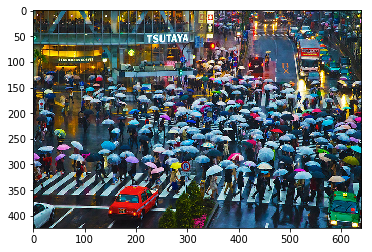

In [65]:
img_file = "/Users/ctang/dev/simple-rcnn/images/shibuya.jpg"
image = cv2.imread(img_file)

# OpenCV loads images in BGR format, but Matplotlib assumes they're
# in RGB format. Convert the BGR image to RGB so that the colors are
# displayed properly.
b,g,r = cv2.split(image)
rgb_image = cv2.merge([r,g,b])

plt.imshow(rgb_image)

# Region Proposal
Use Selective Search to detect regions that *might* contain a person, and draw green bounding boxes around those regions.

In [68]:
def get_regions(img):
    pickle_filepath = 'data/bboxes.p'
    if os.path.exists(pickle_filepath):
        with open(pickle_filepath, 'rb') as f:
            pimg, bboxes = pickle.load(f)
        if np.array_equal(img, pimg):
            print("Using serialized regions.")
            return bboxes
    
    region_proposer = region.RegionProposer()
    start = time.time()
    bboxes = region_proposer.get_regions(img)
    end = time.time()
    print("Calculated %d regions in %f seconds." % (len(bboxes), end - start))
    with open(pickle_filepath, 'wb') as f:
        pickle.dump((img, bboxes), f)
        print("Regions serialized in", f.name)
    return bboxes

bboxes = get_regions(rgb_image)

Using serialized regions.


Found 6366 regions. Displaying 200 of them.


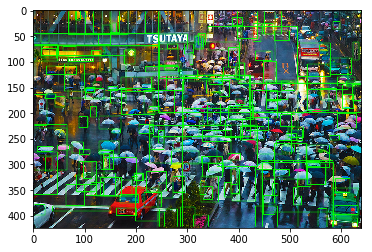

In [73]:
num_regions_to_display = 200
print("Found %d regions. Displaying %d of them." % (len(bboxes), num_regions_to_display))

image_copy = rgb_image.copy()
for bbox in bboxes[:num_regions_to_display]:
    x, y, w, h = bbox
    cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(image_copy)

Let's inspect how one of the regions looks.

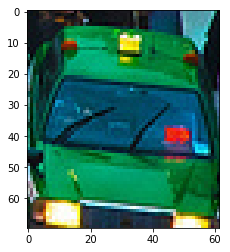

In [70]:
x, y, w, h = bboxes[3772]
bbox = rgb_image[y:y+h, x:x+w]
plt.imshow(bbox)

Let's inspect 16 regions warped so that they can be fed through a convolutional neural network.

4582


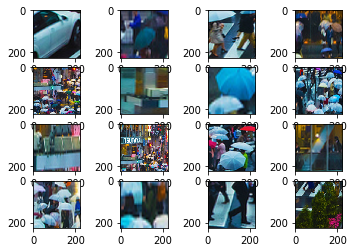

In [74]:
import random
num_bboxes = len(bboxes)
rand_start_pos = random.randint(0, num_bboxes-1)
print(rand_start_pos)
for i, bbox in enumerate(bboxes[rand_start_pos:rand_start_pos+16]):
    x, y, w, h = bbox
    region = rgb_image[y:y+h, x:x+w]
    warped_region = cv2.resize(region, (225, 225), interpolation=cv2.INTER_LINEAR)
    plt.subplot(4, 4, i+1)
    plt.imshow(warped_region)
plt.show()

# Classification
Let's classify one region for now.

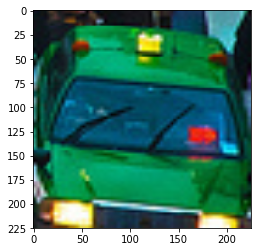

In [75]:
x, y, w, h = bboxes[3772]
region = rgb_image[y:y+h, x:x+w]
warped_region = cv2.resize(region, (225, 225), interpolation=cv2.INTER_LINEAR)
plt.imshow(warped_region)

# Copied code from PyTorch Classification Tutorial
Follow the tutorial here: http://blog.outcome.io/pytorch-quick-start-classifying-an-image/

/Users/ctang/miniconda3/envs/cs231n/lib/python3.5/site-packages/torchvision-0.2.0-py3.5.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


garbage truck, dustcart


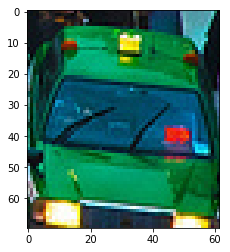

In [77]:
import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable

LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'https://food.fnr.sndimg.com/content/dam/images/food/fullset/2011/10/19/0/CC_Eggnog-Recipe-1_s4x3.jpg.rend.hgtvcom.616.462.suffix/1382540852926.jpeg'
squeeze = models.squeezenet1_1(pretrained=True)

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Scale(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   normalize
])

response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
region_pil = Image.fromarray(region)

# img_to_classify = img_pil # replace with region_pil if you just want to classify a region from nima.jpg
img_to_classify = region_pil

plt.imshow(img_to_classify)

img_tensor = preprocess(img_to_classify)
img_tensor.unsqueeze_(0)

img_variable = Variable(img_tensor)
fc_out = squeeze(img_variable)

labels = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}
print(labels[fc_out.data.numpy().argmax()])

# R-CNN Algorithm
* compute 2,000 regions in an image
* warp each region
* forward propagate each region through CNN to produce an extracted **feature vector**
* for every class C, score the **feature vector** with an SVM trained for that class. For example, score the feature vector for the cat class.
* I don't understand this next step: *"Given all scored regions in an image, we apply a
greedy non-maximum suppression (for each class independently)
that rejects a region if it has an intersection-overunion
(IoU) overlap with a higher scoring selected region
larger than a learned threshold."*

In [78]:
import math
from collections import defaultdict

batch_size = 256
num_bboxes = len(bboxes)
num_batches = math.ceil(num_bboxes / batch_size)

print("Batch size: %d" % batch_size)
print("Number of bboxes: %d" % num_bboxes)
print("Number of batches: %d" % num_batches)

batches = defaultdict(list)

for i, bbox in enumerate(bboxes):
    # process region
    
    # Determine batch that region belongs to
    batch_idx = i // batch_size
    
    batches[batch_idx].append(bbox)

for k in batches:
    print("# of regions in batch %3d: %d" % (k, len(batches[k])))

last_batch_idx = len(batches) - 1
print("Batches properly sized: ", len(batches[last_batch_idx]) == (num_bboxes % batch_size))

Batch size: 256
Number of bboxes: 6366
Number of batches: 25
# of regions in batch   0: 256
# of regions in batch   1: 256
# of regions in batch   2: 256
# of regions in batch   3: 256
# of regions in batch   4: 256
# of regions in batch   5: 256
# of regions in batch   6: 256
# of regions in batch   7: 256
# of regions in batch   8: 256
# of regions in batch   9: 256
# of regions in batch  10: 256
# of regions in batch  11: 256
# of regions in batch  12: 256
# of regions in batch  13: 256
# of regions in batch  14: 256
# of regions in batch  15: 256
# of regions in batch  16: 256
# of regions in batch  17: 256
# of regions in batch  18: 256
# of regions in batch  19: 256
# of regions in batch  20: 256
# of regions in batch  21: 256
# of regions in batch  22: 256
# of regions in batch  23: 256
# of regions in batch  24: 222
Batches properly sized:  True
